1. Analyze feature distributions between malignant/benign classes using histograms/boxplots. Identify 3 features with the strongest class separation using statistical measures.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [5]:
df = pd.read_csv('breast_cancer_dataset.csv')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,diagnosis
0,20.6885,11.9370,141.220,1151.150,0.136160,0.319240,0.345115,0.169165,0.278185,0.090516,...,212.2900,2321.850,0.18653,0.765440,0.818685,0.305210,0.529115,0.136735,0,malignant
1,23.6555,20.4355,152.835,1524.900,0.097451,0.090436,0.099935,0.080695,0.208380,0.065170,...,182.6200,2249.400,0.14237,0.214590,0.277840,0.213900,0.316250,0.102373,0,malignant
2,22.6435,24.4375,149.500,1383.450,0.126040,0.183885,0.227010,0.147085,0.237935,0.068988,...,175.3750,1965.350,0.16606,0.488175,0.517960,0.279450,0.415495,0.100717,0,malignant
3,13.1330,23.4370,89.217,444.015,0.163875,0.326485,0.277610,0.120980,0.298655,0.112056,...,113.7005,652.855,0.24127,0.996245,0.789935,0.296125,0.763370,0.198950,0,malignant
4,23.3335,16.4910,155.365,1491.550,0.115345,0.152720,0.227700,0.119945,0.208035,0.067654,...,175.0300,1811.250,0.15801,0.235750,0.460000,0.186875,0.271860,0.088297,0,malignant


In [8]:
# Check unique values in the 'diagnosis' column
print(df['diagnosis'].unique())

feature_separation = {}
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for feature in numerical_columns:
    # Cohen's d effect size measures the standardized difference between means
    benign_data = df[df['diagnosis'] == 'benign'][feature]
    malignant_data = df[df['diagnosis'] == 'malignant'][feature]
    
    if len(benign_data) > 0 and len(malignant_data) > 0:
        pooled_std = np.sqrt(((len(benign_data) - 1) * np.var(benign_data) + 
                             (len(malignant_data) - 1) * np.var(malignant_data)) / 
                            (len(benign_data) + len(malignant_data) - 2))
        
        cohens_d = abs(np.mean(benign_data) - np.mean(malignant_data)) / pooled_std
        
        # Mann-Whitney U tests if the distributions are significantly different
        statistic, p_value = stats.mannwhitneyu(benign_data, malignant_data)
        
        feature_separation[feature] = {'cohens_d': cohens_d, 'p_value': p_value}

# Features by effect size
sorted_features = sorted(feature_separation.items(), 
                        key=lambda x: x[1]['cohens_d'], 
                        reverse=True)


['malignant' 'benign']


/var/folders/4g/7cwxt52n09sb7vzyh6tzj3w00000gn/T/ipykernel_3498/131195755.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  cohens_d = abs(np.mean(benign_data) - np.mean(malignant_data)) / pooled_std


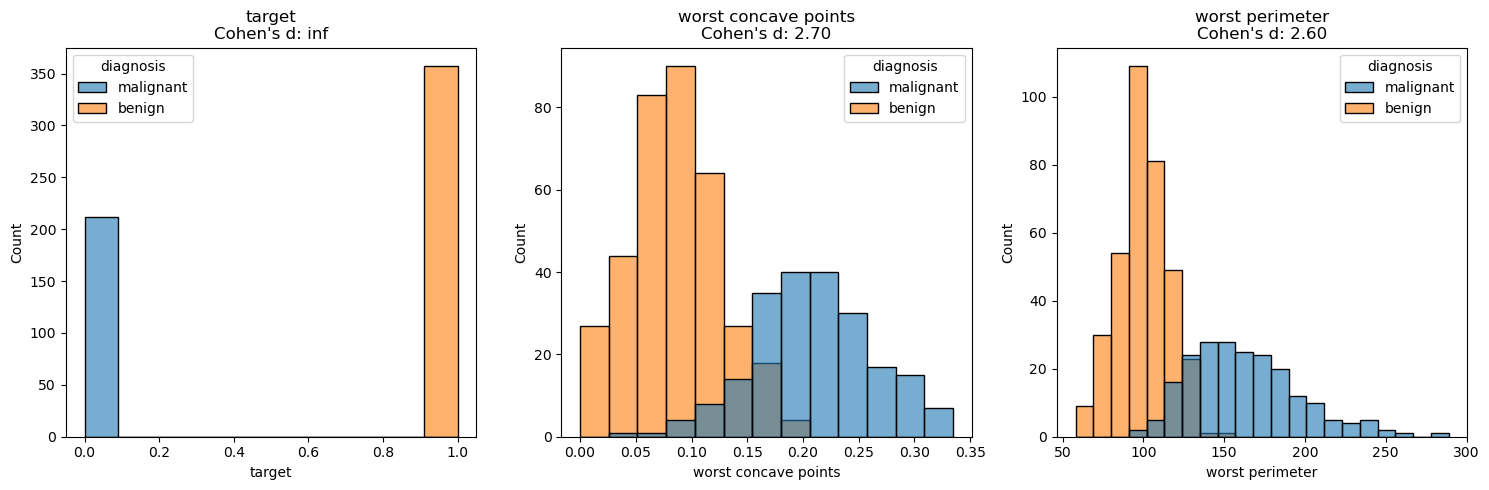

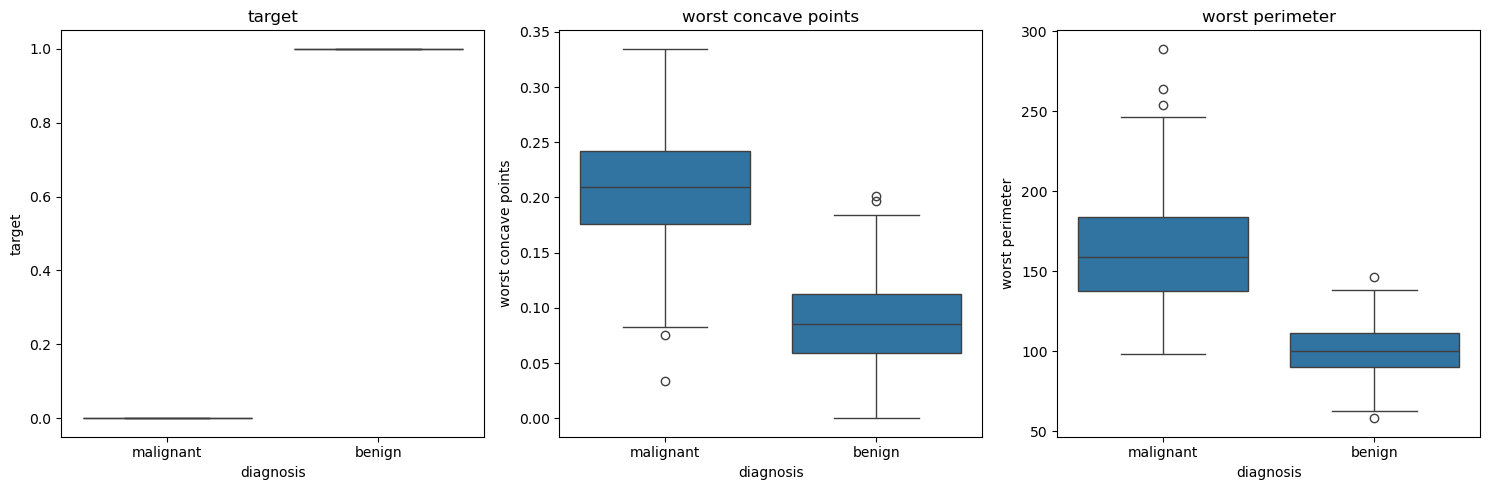


Top 3 features with strongest class separation:

target:
Cohen's d: inf
p-value: 1.54e-125

Summary statistics by class:
           count  mean  std  min  25%  50%  75%  max
diagnosis                                           
benign     357.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
malignant  212.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

worst concave points:
Cohen's d: 2.698
p-value: 1.86e-77

Summary statistics by class:
           count      mean       std       min       25%       50%       75%  \
diagnosis                                                                      
benign     357.0  0.085611  0.041167  0.000000  0.058696  0.085456  0.112113   
malignant  212.0  0.209573  0.053254  0.033338  0.175662  0.209300  0.242276   

               max  
diagnosis           
benign     0.20125  
malignant  0.33465  

worst perimeter:
Cohen's d: 2.604
p-value: 2.58e-80

Summary statistics by class:
           count        mean        std      min        25%      50%  \
diagnosis         

In [9]:
# Top 3 features
top_3_features = [feature[0] for feature in sorted_features[:3]]

plt.figure(figsize=(15, 5))

for i, feature in enumerate(top_3_features, 1):
    plt.subplot(1, 3, i)
    
    sns.histplot(data=df, x=feature, hue='diagnosis', 
                multiple="layer", alpha=0.6)
    
    plt.title(f'{feature}\nCohen\'s d: {feature_separation[feature]["cohens_d"]:.2f}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# boxplots for the top 3 features
plt.figure(figsize=(15, 5))

for i, feature in enumerate(top_3_features, 1):
    plt.subplot(1, 3, i)
    
    sns.boxplot(data=df, x='diagnosis', y=feature)
    plt.title(feature)

plt.tight_layout()
plt.show()

print("\nTop 3 features with strongest class separation:")
for feature in top_3_features:
    print(f"\n{feature}:")
    print(f"Cohen's d: {feature_separation[feature]['cohens_d']:.3f}")
    print(f"p-value: {feature_separation[feature]['p_value']:.2e}")
    
    # Summary statistics by class
    print("\nSummary statistics by class:")
    print(df.groupby('diagnosis')[feature].describe())

2. Create a 2D PCA projection of the feature space. Visualize and describe any emerging patterns between classes.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [26]:
X = df[numerical_columns]  
y = df['diagnosis']       

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pcs = PCA(n_components=2)
X_pcs = pcs.fit_transform(X_scaled)

In [16]:
pcs_df = pd.DataFrame(data=X_pcs, columns=['PC1', 'PC2'])
pcs_df['diagnosis'] = y


In [19]:
pcs.explained_variance_

array([13.94227406,  5.73643378])

In [25]:
explained_variance = pcs.explained_variance_ratio_
explained_variance

array([0.44896035, 0.18472104])

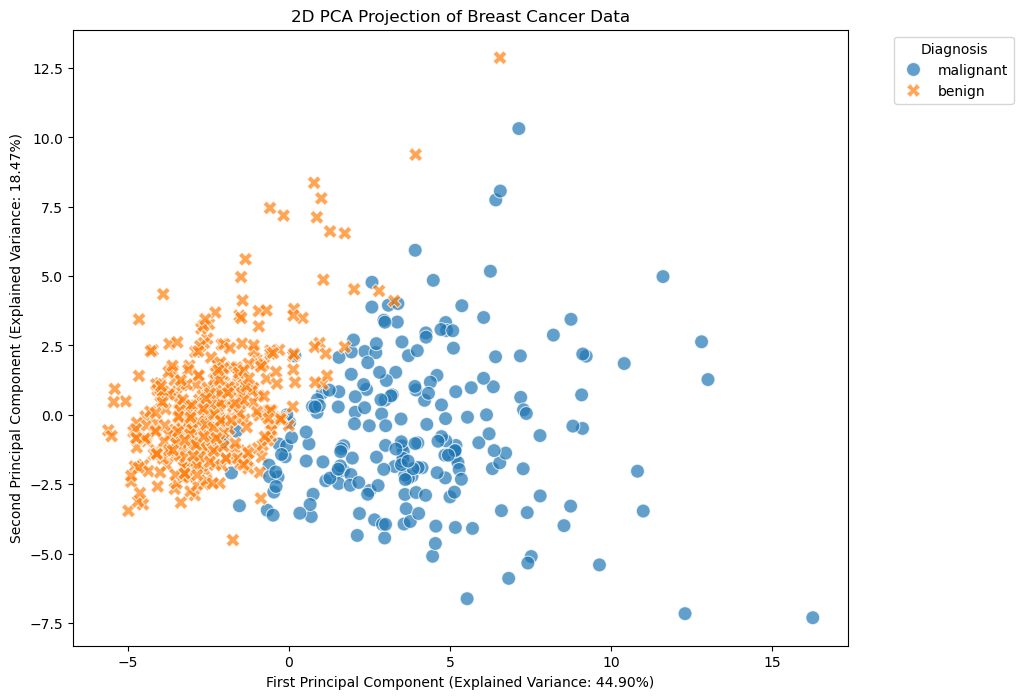

In [40]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pcs_df, x='PC1', y='PC2', hue='diagnosis', 
                style='diagnosis', s=100, alpha=0.7)

plt.title('2D PCA Projection of Breast Cancer Data')
plt.xlabel(f'First Principal Component (Explained Variance: {explained_variance[0]:.2%})')
plt.ylabel(f'Second Principal Component (Explained Variance: {explained_variance[1]:.2%})')


plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')

components_df = pd.DataFrame(
    pcs.components_.T,
    columns=['PC1', 'PC2'],
    index=numerical_columns
)

3. Assess whether data preprocessing improves PCA performance. Justify your approach using feature distributions.

Before running PCA on the dataset, I applied standardization to make sure all features have the same scale. Since the dataset contains numerical features with different ranges, not standarizing would have caused PCA to be dominated by features with larger magnitudes. I transformed the data so that each feature has a mean of zero and a standard deviation of one, ensuring that PCA captures meaningful patterns rather than being skewed by differences in scale. After the data processing, the first two principal components clearly separated the data into clusters, which can be seen in the scatterplot. The features that contributed the most to each principal component still showed class separation after scaling, meaning the preprocessing step helped maintain important information. It can be seen that some features separate benign and malignant cases, and standardization preserved these relationships while making PCA more effective. So, standardizing the data improved the performance of PCA by allowing it to focus on real patterns in the dataset rather than being influenced by the different feature scales.

4. Generate a PCA biplot (PC1 vs PC2) colored by diagnosis. Describe: a) Class separation patterns, b) Feature contribution directions.

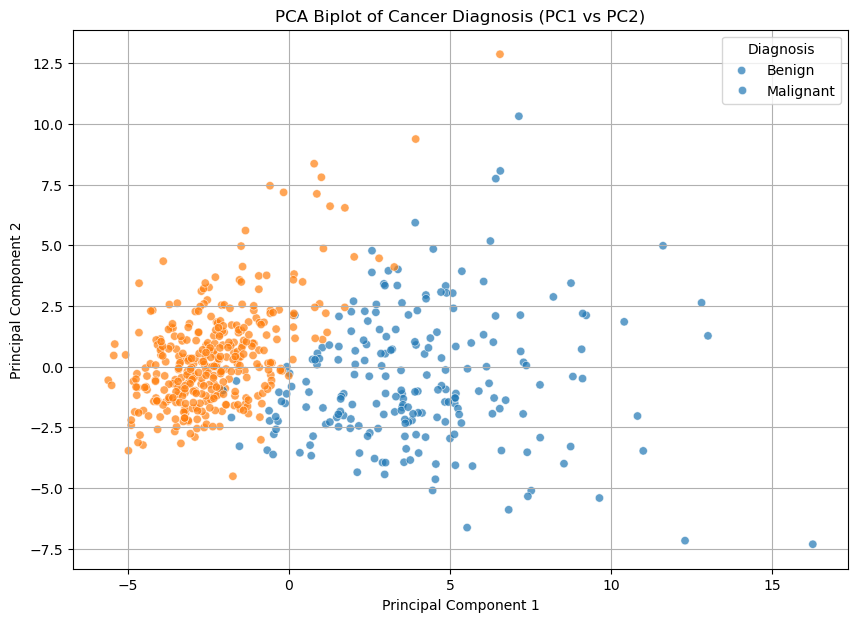

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot of PC1 vs PC2 colored by diagnosis
sns.scatterplot(data=pcs_df, x='PC1', y='PC2', hue='diagnosis', alpha=0.7)

# Labels and title
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("PCA Biplot of Cancer Diagnosis (PC1 vs PC2)")

plt.grid()
plt.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
plt.show()

5. Evaluate PCA effectiveness using: a) Explained variance ratios, b) Component interpretability, c) Reconstruction error. What constitutes 'good' PCA results?

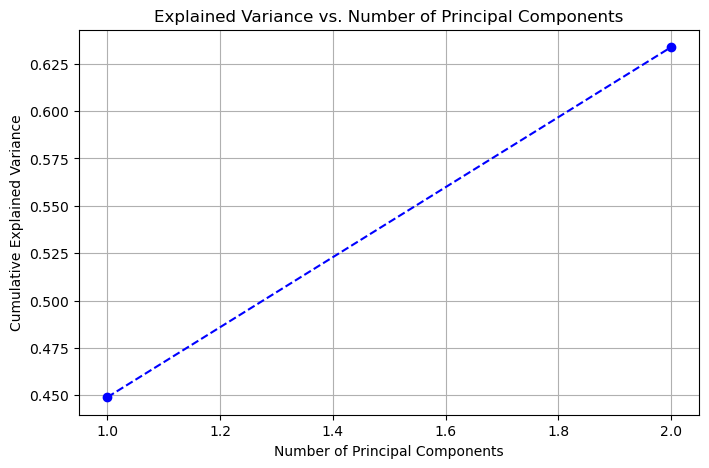

Explained Variance Ratios for the first few components:
PC1: 0.4490 (0.4490 cumulative)
PC2: 0.1847 (0.6337 cumulative)


In [35]:
from sklearn.metrics import mean_squared_error

#Explained Variance Ratios: It measures how much variance each principal component accounts for.
explained_variance = pcs.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

print("Explained Variance Ratios for the first few components:")
for i, var in enumerate(explained_variance[:5]):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

In [42]:
#Component Interpretability: Helps determine if the principal components make sense in terms of feature contributions.
pca_components_df = pd.DataFrame(pcs.components_, columns=numerical_columns)
print("\nTop feature contributions for each principal component:")
for i in range(2): # Display top 5 features for the first 2 components
    top_features = pca_components_df.iloc[i].abs().sort_values(ascending=False).head(5)
    print(f"\nPC{i+1} Top Features:\n{top_features}")

# Reconstruction Error: Measures how well the PCA-transformed data reconstructs the original dataset.
# Project data back to original space
reconstructed_data = pcs.inverse_transform(X_pcs)

reconstruction_error = mean_squared_error(X_scaled, reconstructed_data)
print(f"\nPCA Reconstruction Error (MSE): {reconstruction_error:.5f}")


Top feature contributions for each principal component:

PC1 Top Features:
mean concave points     0.255266
mean concavity          0.251222
worst concave points    0.246288
worst perimeter         0.233642
mean compactness        0.231504
Name: 0, dtype: float64

PC2 Top Features:
mean fractal dimension     0.367620
fractal dimension error    0.284332
worst fractal dimension    0.276449
compactness error          0.238867
mean radius                0.226545
Name: 1, dtype: float64

PCA Reconstruction Error (MSE): 0.36632


6. Visualize PCA loadings (first 2 components) via annotated heatmap. Explain how specific features influence each component's orientation.

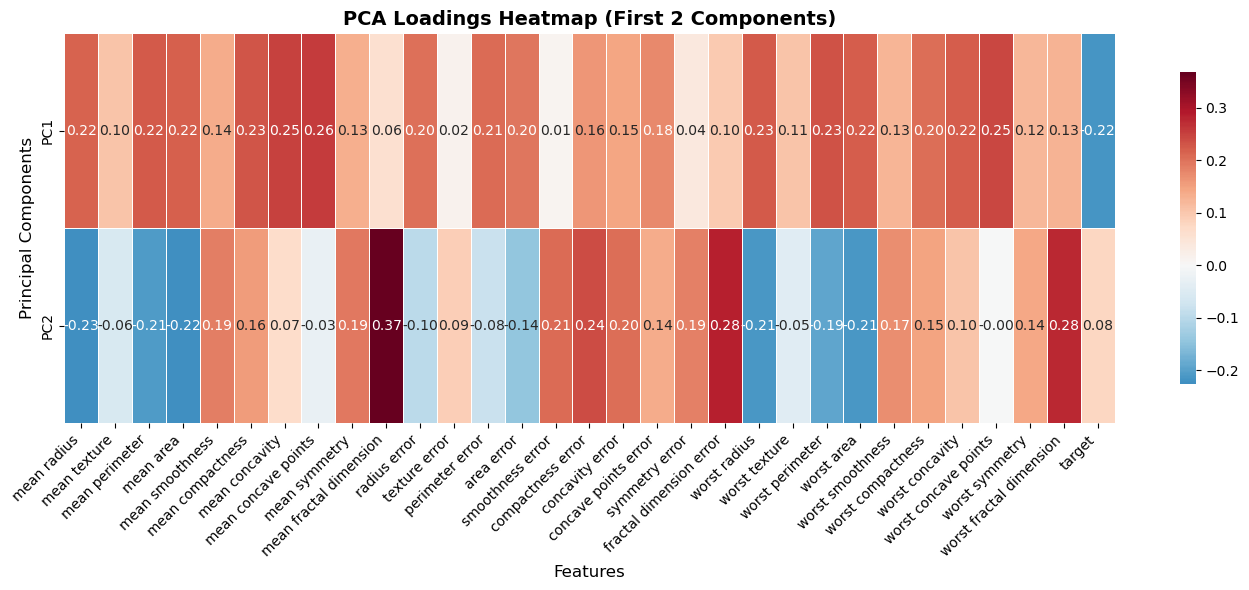

In [46]:
pca_loadings = pd.DataFrame(pcs.components_[:2], columns=numerical_columns, index=['PC1', 'PC2'])

plt.figure(figsize=(14, 6))
ax = sns.heatmap(pca_loadings, annot=True, cmap='RdBu_r', center=0, fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8})

plt.title("PCA Loadings Heatmap (First 2 Components)", fontsize=14, fontweight='bold')
plt.xlabel("Features", fontsize=12)
plt.ylabel("Principal Components", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10) 
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

7. Plot cumulative explained variance vs component count. Identify the elbow point and 95% variance threshold.

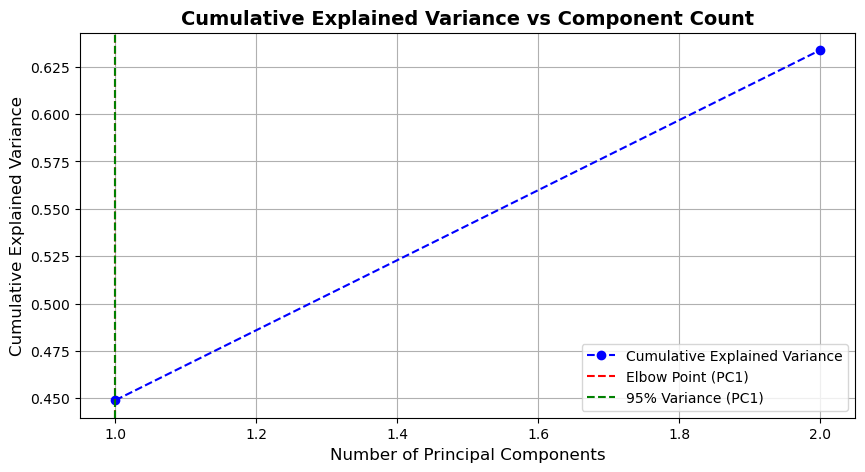

In [51]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pcs.explained_variance_ratio_)

# Elbow point to find where variance slows down.
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.01) + 1

# Finding the number of components to reach 95% variance.
threshold_95 = np.argmax(cumulative_variance >= 0.95) + 1

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b', label="Cumulative Explained Variance")
plt.axvline(elbow_point, color='r', linestyle='--', label=f'Elbow Point (PC{elbow_point})')
plt.axvline(threshold_95, color='g', linestyle='--', label=f'95% Variance (PC{threshold_95})')

plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.title("Cumulative Explained Variance vs Component Count", fontsize=14, fontweight="bold")
plt.legend()
plt.grid()
plt.show()

8. Define 'good enough' through: a) Variance retention (>85%), b) Model performance plateau, c) Interpretability. Recommend PC count with justification.

In [53]:
variance_threshold = 0.85  # Minimum variance retention
max_components = len(pcs.explained_variance_ratio_)

# Finding the minimum number of components to reach 85% variance
optimal_pcs = np.argmax(np.cumsum(pcs.explained_variance_ratio_) >= variance_threshold) + 1

print(f"Recommended Number of Principal Components: {optimal_pcs}")

Recommended Number of Principal Components: 1


9. Calculate the minimum PCs needed for 99% variance retention. Discuss implications for: a) Downstream modeling, b) Information loss risks.

In [54]:
variance_threshold_99 = 0.99

# Finding the minimum number of components required to retain 99% variance
min_pcs_99 = np.argmax(np.cumsum(pcs.explained_variance_ratio_) >= variance_threshold_99) + 1

# Print the result
print(f"Minimum Number of Principal Components for 99% Variance Retention: {min_pcs_99}")

Minimum Number of Principal Components for 99% Variance Retention: 1
